<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_1704_feature_engineering_03_feature_selection_07_unsupervised_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Descriptions of Unsupervised Methods for Feature Selection

#### 1. **Principal Component Analysis (PCA)**
- **Description**: PCA is a dimensionality reduction technique that transforms the original features into a new set of uncorrelated features called principal components. These components are linear combinations of the original features, ordered by the amount of variance they capture in the data.
- **How it Works**:
  1. Standardize the data.
  2. Compute the covariance matrix.
  3. Perform eigenvalue decomposition of the covariance matrix to obtain eigenvalues and eigenvectors.
  4. Select the top principal components that capture the most variance.
- **Strengths**: Reduces dimensionality while retaining most of the variance in the data. Useful for visualizing high-dimensional data.
- **Limitations**: The new features (principal components) are linear combinations of the original features and may not be easily interpretable.

#### 2. **Factor Analysis**
- **Description**: Factor Analysis is a statistical method used to identify underlying relationships between variables by modeling observed variables as linear combinations of potential latent factors. It aims to explain the variances and covariances among observed variables using fewer unobserved factors.
- **How it Works**:
  1. Standardize the data.
  2. Estimate the covariance matrix.
  3. Extract initial factors using methods like Principal Axis Factoring or Maximum Likelihood Estimation.
  4. Rotate the factors to achieve a simpler and more interpretable structure.
- **Strengths**: Identifies latent variables that can explain observed data variances. Useful for reducing dimensionality and uncovering hidden structures.
- **Limitations**: Assumes linear relationships and may require careful interpretation of the latent factors.

#### 3. **Autoencoders**
- **Description**: Autoencoders are neural networks designed to learn efficient codings of input data in an unsupervised manner. They consist of an encoder that maps the input to a lower-dimensional representation and a decoder that reconstructs the input from this representation.
- **How it Works**:
  1. The encoder network compresses the input into a lower-dimensional latent space.
  2. The decoder network attempts to reconstruct the original input from the latent representation.
  3. The network is trained to minimize the reconstruction error.
- **Strengths**: Can capture complex, non-linear relationships in the data. Effective for reducing dimensionality and feature extraction in large, high-dimensional datasets.
- **Limitations**: Requires a significant amount of data for training. The quality of the learned representation depends on the architecture and training process.

### Application and Use Cases
- **PCA**: Suitable for datasets where capturing the most variance is important. Commonly used for visualization and as a preprocessing step for other machine learning algorithms.
- **Factor Analysis**: Useful for uncovering latent structures in the data. Often applied in fields like psychology and social sciences to identify underlying factors.
- **Autoencoders**: Effective for high-dimensional data, especially when non-linear relationships exist. Used in image compression, anomaly detection, and feature extraction for complex datasets.

### Summary
These unsupervised methods provide various techniques for reducing the dimensionality of the data and extracting meaningful features. They are particularly useful when you do not have labeled data or when you want to preprocess data before applying supervised learning techniques.

## Baseline Performance

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, OrdinalEncoder
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.model_selection import cross_val_score
import json
import warnings
from loan_data_utils import load_and_preprocess_data, plot_classification_report_metrics, ThresholdClassifier, plot_selected_features, save_experiment_results
from loan_data_feature_engineering import *

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Define your URL, categorical columns, and target
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'marriage', 'education']
target = 'default_payment_next_month'

# Load and preprocess data
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = ['sex', 'marriage']
# Define the custom ordering for the 'education' variable as ordered category
education_order = [0, 1, 2, 3, 4, 5, 6]

# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('education_ord', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ordinal_encoder', OrdinalEncoder(categories=[education_order]))
        ]), ['education']),  # Treat education separately with ordinal encoding
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_columns)
    ])

# Fit and transform the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Apply SMOTE after preprocessing
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_preprocessed, y_train)

# Use the custom classifier with Logistic Regression and a threshold of 0.3 for class 1
base_classifier = LogisticRegression(max_iter=5000)
classifier = ThresholdClassifier(base_classifier, threshold=0.3)

# Train the classifier on the resampled data
classifier.fit(X_train_res, y_train_res)

# Predict and evaluate on the preprocessed test set
y_pred = classifier.predict(X_test_preprocessed)
baseline_report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

# Initialize a dictionary to store the classification reports
experiment_results = {}
selected_features = {}

# Add the baseline report to the dictionary
experiment_results['baseline'] = baseline_report

# Define the path and filename for the JSON file
json_filename = 'classification_reports_unsupervised_methods.json'

# Save the baseline report to the JSON file using the new unified function
save_experiment_results(experiment_results, selected_features, json_filename)

              precision    recall  f1-score   support

           0       0.88      0.24      0.38      4673
           1       0.25      0.88      0.39      1327

    accuracy                           0.38      6000
   macro avg       0.56      0.56      0.38      6000
weighted avg       0.74      0.38      0.38      6000

Experiment results saved to classification_reports_unsupervised_methods.json


## Feature Engineering Model

Dropping the original columns after binning is generally a good approach if the binned versions capture the information you need. However, it’s important to consider a few factors:

### Potential Issues to Consider:

1. **Loss of Detailed Information**:
   - Binning transforms continuous variables into discrete categories, which can lead to some loss of information. For example, specific nuances in the original continuous values might be lost when aggregated into bins.

2. **Impact on Model Performance**:
   - Some models, especially linear models, may perform better with the original continuous features compared to binned categories. Dropping the original continuous features could impact performance, so it’s important to validate this with experiments.

3. **Interaction with Other Features**:
   - If your feature engineering pipeline relies on interactions between the original features and others, dropping the original columns might cause issues or lead to unintended consequences.

### When It’s a Good Idea:
- **Simplified Features**: If the binned versions are more interpretable and simplify the model without significantly impacting performance.
- **Reducing Multicollinearity**: If the original continuous features are highly correlated with other features, replacing them with their binned versions can help reduce multicollinearity.

### Suggested Approach:
You can implement a solution where you drop the original features after binning and validate whether this approach benefits model performance:

### How to Proceed:
1. **Test Performance**: Run experiments comparing the performance of your model with and without the original continuous features.
2. **Validate Interpretability**: Determine whether the binned features still provide useful insights or if dropping the original features leads to a significant loss of information.

If dropping the original features after binning maintains or improves performance, this approach could simplify your model while retaining the key information from the features. Let me know if you need further assistance!

In [8]:
# Get the feature names from the preprocessor
numeric_feature_names = numeric_features
ordinal_feature_names = ['education']  # Since it's now processed as an ordinal category
onehot_feature_names = list(preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_columns))

# Combine the feature names
all_feature_names = numeric_feature_names + ordinal_feature_names + onehot_feature_names

# Convert the preprocessed data to DataFrames with the correct feature names
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=all_feature_names)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=all_feature_names)

# Define your custom interaction pairs
interaction_pairs = [
    ('limit_bal', 'age'),
    ('limit_bal', 'pay_1'),
    ('limit_bal', 'pay_2'),
    ('bill_amt1', 'pay_amt1'),
    ('marriage_1', 'pay_1'),
    ('education_5', 'pay_1'),
    ('sex_2', 'pay_1'),
    ('marriage_1', 'pay_2'),
    ('sex_2', 'marriage_2'),
]

# Step 1: Apply Interaction Features First
interaction_pipeline = Pipeline(steps=[
    ('interaction', CustomInteractionFeatures(interaction_pairs=interaction_pairs))
])

# Step 2: Then Apply Feature Engineering Pipeline
features_to_bin = ['bill_amt1', 'pay_amt1', 'limit_bal']

feature_engineering_pipeline = Pipeline(steps=[
    ('ratio', RatioFeatures()),
    ('binning', SelectiveBinningFeaturesOneHot(features_to_bin, n_bins=5, encode='onehot', strategy='quantile', drop_original=False))
])

# Combine Interaction Pipeline with the Feature Engineering Pipeline
full_pipeline = Pipeline(steps=[
    ('interaction', interaction_pipeline),
    ('feature_engineering', feature_engineering_pipeline)
])

# Apply the full pipeline to the training data
X_train_fe = full_pipeline.fit_transform(X_train_preprocessed_df)
X_test_fe = full_pipeline.transform(X_test_preprocessed_df)

# Apply SMOTE after feature engineering
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_fe, y_train)

# Now you can proceed with model training
classifier = LogisticRegression(max_iter=5000, solver='saga', C=0.1)
classifier.fit(X_train_res, y_train_res)

# Evaluate on the test set
y_pred_fe = classifier.predict(X_test_fe)
fe_report = classification_report(y_test, y_pred_fe, output_dict=True)
print(classification_report(y_test, y_pred_fe))

# Add the current experiment report to the dictionary
experiment_results['feature_engineering'] = fe_report

# Save the updated experiment results to the JSON file using the new unified function
save_experiment_results(experiment_results, selected_features, json_filename)


              precision    recall  f1-score   support

           0       0.88      0.78      0.82      4673
           1       0.44      0.62      0.51      1327

    accuracy                           0.74      6000
   macro avg       0.66      0.70      0.67      6000
weighted avg       0.78      0.74      0.76      6000

Experiment results saved to classification_reports_unsupervised_methods.json


In [9]:
# Check for NaNs before feature engineering
print("NaN values before feature engineering:")
print(X_train_preprocessed_df[features_to_bin].isnull().sum())

# Apply Feature Engineering Pipeline
X_train_fe = full_pipeline.fit_transform(X_train_preprocessed_df)
X_test_fe = full_pipeline.transform(X_test_preprocessed_df)

# Convert back to DataFrame for easier inspection
X_train_fe_df = pd.DataFrame(X_train_fe, columns=all_feature_names)
X_test_fe_df = pd.DataFrame(X_test_fe, columns=all_feature_names)

# Check for NaNs after feature engineering
print("NaN values after feature engineering:")
print(X_train_fe_df[features_to_bin].isnull().sum())


NaN values before feature engineering:
bill_amt1    0
pay_amt1     0
limit_bal    0
dtype: int64
NaN values after feature engineering:
bill_amt1    0
pay_amt1     0
limit_bal    0
dtype: int64


## PCA for Continuous Data

You’re absolutely right to ask why categorical data, once one-hot encoded, can’t be used with methods like PCA and Factor Analysis. Technically, you **can** apply these methods to one-hot encoded categorical data, but the effectiveness and interpretation of the results can be problematic. Let’s break down the reasoning:

### Why PCA and Factor Analysis May Not Be Ideal for One-Hot Encoded Data:

1. **Nature of One-Hot Encoded Data:**
    - One-hot encoding creates binary columns (0s and 1s) for each category.
    - PCA and Factor Analysis are designed to capture linear relationships and continuous variance. They assume the input features are continuous and linearly related.

2. **Variance in One-Hot Encoded Data:**
    - In one-hot encoded columns, most values are 0, with only a few 1s scattered across the rows. This sparse structure makes it hard for methods like PCA or Factor Analysis to capture meaningful variance, leading to components that don’t add much value.

3. **Interpretation Issues:**
    - When PCA or Factor Analysis reduces dimensionality, it combines features into principal components or latent factors. For one-hot encoded data, these components might mix categories in ways that are hard to interpret or make little logical sense.

4. **Loss of Categorical Meaning:**
    - By mixing binary indicators from one-hot encoding, the reduced features lose their original categorical meaning, making the results difficult to understand.



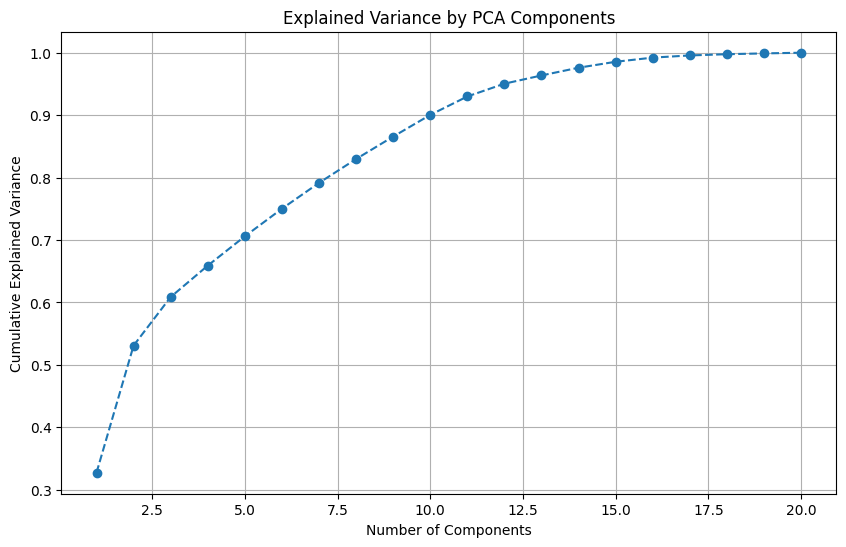

Optimal number of components: 12
              precision    recall  f1-score   support

           0       0.88      0.78      0.82      4673
           1       0.44      0.61      0.51      1327

    accuracy                           0.74      6000
   macro avg       0.66      0.69      0.67      6000
weighted avg       0.78      0.74      0.75      6000

Experiment results saved to classification_reports_unsupervised_methods.json


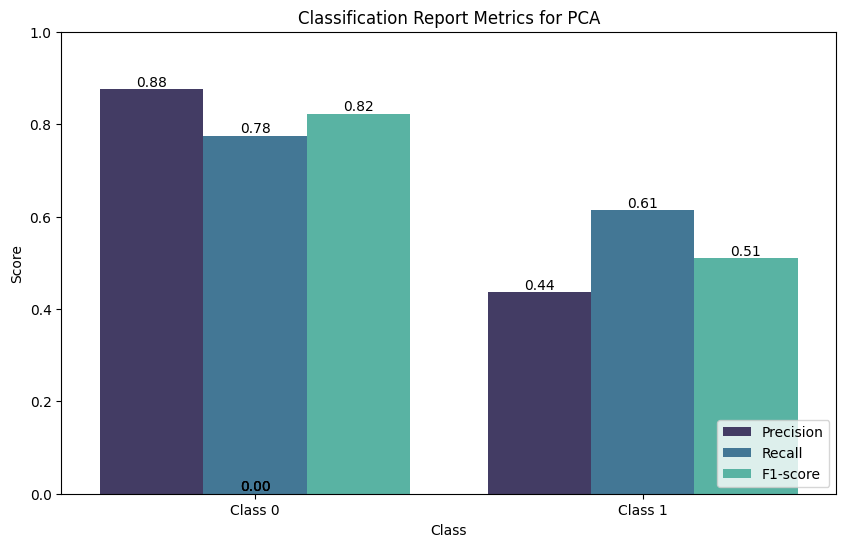

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import json
import warnings
from loan_data_utils import load_and_preprocess_data, plot_classification_report_metrics, ThresholdClassifier, plot_selected_features, save_experiment_results
from loan_data_feature_engineering import *

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Define your URL, categorical columns, and target
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'marriage', 'education']
target = 'default_payment_next_month'

# Load and preprocess data
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = ['sex', 'marriage']
education_order = [0, 1, 2, 3, 4, 5, 6]

# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('education_ord', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ordinal_encoder', OrdinalEncoder(categories=[education_order]))
        ]), ['education']),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_columns)
    ])

# Fit and transform the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Combine the feature names after preprocessing
numeric_feature_names = numeric_features
ordinal_feature_names = ['education']  # Processed as an ordinal category
onehot_feature_names = list(preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_columns))

# Combine all feature names
all_feature_names = numeric_feature_names + ordinal_feature_names + onehot_feature_names

# Convert the preprocessed data to DataFrames with the correct feature names
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=all_feature_names)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=all_feature_names)

# Define your custom interaction pairs
interaction_pairs = [
    ('limit_bal', 'age'),
    ('limit_bal', 'pay_1'),
    ('limit_bal', 'pay_2'),
    ('bill_amt1', 'pay_amt1'),
    ('marriage_1', 'pay_1'),
    ('education_5', 'pay_1'),
    ('sex_2', 'pay_1'),
    ('marriage_1', 'pay_2'),
    ('sex_2', 'marriage_2'),
]

# Step 1: Apply Interaction Features First
interaction_pipeline = Pipeline(steps=[
    ('interaction', CustomInteractionFeatures(interaction_pairs=interaction_pairs))
])

# Step 2: Then Apply Feature Engineering Pipeline
features_to_bin = ['bill_amt1', 'pay_amt1', 'limit_bal']

feature_engineering_pipeline = Pipeline(steps=[
    ('ratio', RatioFeatures()),
    ('binning', SelectiveBinningFeaturesOneHot(features_to_bin, n_bins=5, encode='onehot', strategy='quantile', drop_original=False))
])

# Combine Interaction Pipeline with the Feature Engineering Pipeline
full_pipeline = Pipeline(steps=[
    ('interaction', interaction_pipeline),
    ('feature_engineering', feature_engineering_pipeline)
])

# Apply the full pipeline to the training data
X_train_fe = full_pipeline.fit_transform(X_train_preprocessed_df)
X_test_fe = full_pipeline.transform(X_test_preprocessed_df)

# Perform PCA only on numeric columns
numeric_columns = [col for col in X_train_fe_df.columns if col in numeric_feature_names]

pca = PCA()
X_train_numeric = X_train_fe_df[numeric_columns]
X_test_numeric = X_test_fe_df[numeric_columns]

pca.fit(X_train_numeric)

# Plot the explained variance to choose the number of components
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

# Select the number of components that explain at least 95% of the variance
n_components = np.argmax(explained_variance >= 0.95) + 1
print(f'Optimal number of components: {n_components}')

# Transform the numeric data using the selected number of PCA components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_numeric)
X_test_pca = pca.transform(X_test_numeric)

# Convert the PCA components to DataFrames and ensure the column names are strings
X_train_pca_df = pd.DataFrame(X_train_pca, columns=[f'pca_{i}' for i in range(X_train_pca.shape[1])])
X_test_pca_df = pd.DataFrame(X_test_pca, columns=[f'pca_{i}' for i in range(X_test_pca.shape[1])])

# Combine the PCA components back with the categorical data
X_train_final = pd.concat([X_train_pca_df, X_train_fe_df.drop(columns=numeric_columns).reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_pca_df, X_test_fe_df.drop(columns=numeric_columns).reset_index(drop=True)], axis=1)

# Ensure all column names are strings
X_train_final.columns = X_train_final.columns.astype(str)
X_test_final.columns = X_test_final.columns.astype(str)

# Apply SMOTE after PCA and feature engineering
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_final, y_train)

# Train the final model
classifier = LogisticRegression(max_iter=5000, solver='saga', C=0.1)
classifier.fit(X_train_res, y_train_res)

# Evaluate on the test set
y_pred_pca = classifier.predict(X_test_final)
classification_report_pca = classification_report(y_test, y_pred_pca, output_dict=True)
print(classification_report(y_test, y_pred_pca))

# Add the current experiment report to the dictionary
experiment_results = {'PCA': classification_report_pca}

# Save the updated experiment results to the JSON file using the new unified function
save_experiment_results(experiment_results, {}, 'classification_reports_unsupervised_methods.json')

# Plot the classification report metrics
plot_classification_report_metrics(classification_report_pca, 'PCA')


#### Feature Engineering Script for PCA


In [29]:
script_content=r'''
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import KBinsDiscretizer, PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder


# ------ Ratio Features ------ #

class RatioFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['bill_ratio'] = np.where(X['limit_bal'] != 0, X['bill_amt1'] / X['limit_bal'], 0)
        X['pay_ratio'] = np.where(X['limit_bal'] != 0, X['pay_amt1'] / X['limit_bal'], 0)
        X['age_income_ratio'] = np.where(X['limit_bal'] != 0, X['age'] / X['limit_bal'], 0)
        return X

    def get_feature_names_out(self, input_features=None):
        return input_features + ['bill_ratio', 'pay_ratio', 'age_income_ratio']

# ----- Binning Features ------ #

class SelectiveBinningFeaturesOneHot(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_bin, n_bins=5, encode='onehot', strategy='quantile', drop_original=True):
        self.features_to_bin = features_to_bin
        self.binner = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
        self.onehot_encoder = OneHotEncoder(sparse_output=False)
        self.other_features = None
        self.encode = encode
        self.drop_original = drop_original

    def fit(self, X, y=None):
        self.binner.fit(X[self.features_to_bin])
        X_binned = self.binner.transform(X[self.features_to_bin])
        if self.encode == 'onehot':
            self.onehot_encoder.fit(X_binned)
        self.other_features = X.drop(columns=self.features_to_bin).columns.tolist()
        return self

    def transform(self, X):
        X_binned = self.binner.transform(X[self.features_to_bin])
        if self.encode == 'onehot':
            X_binned = self.onehot_encoder.transform(X_binned)
            bin_columns = [f'{col}_bin_{i}' for col in self.features_to_bin for i in range(X_binned.shape[1] // len(self.features_to_bin))]
        else:
            bin_columns = [f'{col}_binned' for col in self.features_to_bin]
        X_binned_df = pd.DataFrame(X_binned, columns=bin_columns)
        if self.drop_original:
            return pd.concat([X_binned_df, X[self.other_features].reset_index(drop=True)], axis=1)
        else:
            return pd.concat([X_binned_df, X.reset_index(drop=True)], axis=1)

    def get_feature_names_out(self, input_features=None):
        if self.encode == 'onehot':
            bin_columns = [f'{col}_bin_{i}' for col in self.features_to_bin for i in range(self.binner.n_bins)]
        else:
            bin_columns = [f'{col}_binned' for col in self.features_to_bin]
        if self.drop_original:
            return bin_columns + self.other_features
        else:
            return bin_columns + input_features

# ----- Interaction Features ------ #

class CustomInteractionFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, interaction_pairs):
        self.interaction_pairs = interaction_pairs

    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns if isinstance(X, pd.DataFrame) else [f'feature_{i}' for i in range(X.shape[1])]
        return self

    def transform(self, X):
        interaction_data = pd.DataFrame(index=X.index)
        for pair in self.interaction_pairs:
            if pair[0] in X.columns and pair[1] in X.columns:
                interaction_data[f"{pair[0]}_{pair[1]}"] = X[pair[0]] * X[pair[1]]
            else:
                interaction_data[f"{pair[0]}_{pair[1]}"] = 0  # Default to 0 if interaction is not valid
        return pd.concat([X, interaction_data], axis=1)

    def get_feature_names_out(self, input_features=None):
        interaction_columns = [f"{pair[0]}_{pair[1]}" for pair in self.interaction_pairs]
        return input_features + interaction_columns



# ----- Plotting Functions ------ #

def plot_feature_groups(dataframe, feature_groups, hue):
    for group_name, features in feature_groups.items():
        sns.pairplot(dataframe[features + [hue]], hue=hue, palette='magma')
        plt.suptitle(f"Pairplot of {group_name} Features colored by {hue}", y=1.02)
        plt.show()

def plot_selected_features(selected_features, model_name):
    features = list(selected_features.keys())
    importances = list(selected_features.values())
    plt.figure(figsize=(10, 8))
    sns.barplot(x=importances, y=features, palette='viridis')
    plt.title(f'Selected Features and their Importance for {model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

'''

# Write the script to a file
with open("loan_data_feature_engineering.py", "w") as file:
    file.write(script_content)

print("Script successfully written to loan_data_feature_engineering.py")

# Reload script to make functions available for use
import importlib
import loan_data_feature_engineering
importlib.reload(loan_data_feature_engineering)
from loan_data_feature_engineering import *

Script successfully written to loan_data_feature_engineering.py


In [ ]:
# script_content=r'''
# import pandas as pd
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.preprocessing import KBinsDiscretizer, PolynomialFeatures
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler, OneHotEncoder

# # ------ Ratio Features ------ #

# # class RatioFeatures(BaseEstimator, TransformerMixin):
# #     def fit(self, X, y=None):
# #         return self

# #     def transform(self, X):
# #         X = X.copy()
# #         X['bill_ratio'] = X['bill_amt1'] / X['limit_bal']
# #         X['pay_ratio'] = X['pay_amt1'] / X['limit_bal']
# #         X['age_income_ratio'] = X['age'] / X['limit_bal']
# #         return X

# class RatioFeatures(BaseEstimator, TransformerMixin):
#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         X = X.copy()
#         X['bill_ratio'] = np.where(X['limit_bal'] != 0, X['bill_amt1'] / X['limit_bal'], 0)
#         X['pay_ratio'] = np.where(X['limit_bal'] != 0, X['pay_amt1'] / X['limit_bal'], 0)
#         X['age_income_ratio'] = np.where(X['limit_bal'] != 0, X['age'] / X['limit_bal'], 0)
#         return X


# # ----- Binning Features ------ #

# class BinningFeatures(BaseEstimator, TransformerMixin):
#     def __init__(self, n_bins=5, encode='ordinal', strategy='quantile'):
#         # Explicitly store the parameters as class attributes
#         self.n_bins = n_bins
#         self.encode = encode
#         self.strategy = strategy
#         self.binner = KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy)

#     def fit(self, X, y=None):
#         self.binner.fit(X)
#         self.feature_names_in_ = X.columns if isinstance(X, pd.DataFrame) else [f'feature_{i}' for i in range(X.shape[1])]
#         return self

#     def transform(self, X):
#         X_binned = self.binner.transform(X)
#         return pd.DataFrame(X_binned, columns=[f'{col}_binned' for col in self.feature_names_in_])


# class SelectiveBinningFeaturesOrdinal(BaseEstimator, TransformerMixin):
#     def __init__(self, features_to_bin, n_bins=5, encode='ordinal', strategy='quantile'):
#         self.features_to_bin = features_to_bin
#         self.binner = KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy)
#         self.other_features = None

#     def fit(self, X, y=None):
#         # Fit only the features that need binning
#         self.binner.fit(X[self.features_to_bin])
#         self.other_features = X.drop(columns=self.features_to_bin).columns.tolist()
#         return self

#     def transform(self, X):
#         X_binned = self.binner.transform(X[self.features_to_bin])
#         X_binned_df = pd.DataFrame(X_binned, columns=[f'{col}_binned' for col in self.features_to_bin])
#         return pd.concat([X_binned_df, X[self.other_features].reset_index(drop=True)], axis=1)


# # class SelectiveBinningFeaturesOneHot(BaseEstimator, TransformerMixin):
# #     def __init__(self, features_to_bin, n_bins=5, encode='onehot', strategy='quantile'):
# #         self.features_to_bin = features_to_bin
# #         self.binner = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
# #         self.onehot_encoder = OneHotEncoder(sparse_output=False)
# #         self.other_features = None
# #         self.encode = encode

# #     def fit(self, X, y=None):
# #         # Fit only the features that need binning
# #         self.binner.fit(X[self.features_to_bin])
# #         X_binned = self.binner.transform(X[self.features_to_bin])

# #         # Fit the one-hot encoder if needed
# #         if self.encode == 'onehot':
# #             self.onehot_encoder.fit(X_binned)

# #         self.other_features = X.drop(columns=self.features_to_bin).columns.tolist()
# #         return self

# #     def transform(self, X):
# #         X_binned = self.binner.transform(X[self.features_to_bin])

# #         # Apply one-hot encoding if needed
# #         if self.encode == 'onehot':
# #             X_binned = self.onehot_encoder.transform(X_binned)
# #             bin_columns = [f'{col}_bin_{i}' for col in self.features_to_bin for i in range(X_binned.shape[1] // len(self.features_to_bin))]
# #         else:
# #             bin_columns = [f'{col}_binned' for col in self.features_to_bin]

# #         X_binned_df = pd.DataFrame(X_binned, columns=bin_columns)
# #         return pd.concat([X_binned_df, X[self.other_features].reset_index(drop=True)], axis=1)

# class SelectiveBinningFeaturesOneHot(BaseEstimator, TransformerMixin):
#     def __init__(self, features_to_bin, n_bins=5, encode='onehot', strategy='quantile', drop_original=True):
#         self.features_to_bin = features_to_bin
#         self.binner = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
#         self.onehot_encoder = OneHotEncoder(sparse_output=False)
#         self.other_features = None
#         self.encode = encode
#         self.drop_original = drop_original

#     def fit(self, X, y=None):
#         # Fit only the features that need binning
#         self.binner.fit(X[self.features_to_bin])
#         X_binned = self.binner.transform(X[self.features_to_bin])

#         # Fit the one-hot encoder if needed
#         if self.encode == 'onehot':
#             self.onehot_encoder.fit(X_binned)

#         self.other_features = X.drop(columns=self.features_to_bin).columns.tolist()
#         return self

#     def transform(self, X):
#         X_binned = self.binner.transform(X[self.features_to_bin])

#         # Apply one-hot encoding if needed
#         if self.encode == 'onehot':
#             X_binned = self.onehot_encoder.transform(X_binned)
#             bin_columns = [f'{col}_bin_{i}' for col in self.features_to_bin for i in range(X_binned.shape[1] // len(self.features_to_bin))]
#         else:
#             bin_columns = [f'{col}_binned' for col in self.features_to_bin]

#         X_binned_df = pd.DataFrame(X_binned, columns=bin_columns)

#         # Decide whether to drop the original features
#         if self.drop_original:
#             return pd.concat([X_binned_df, X[self.other_features].reset_index(drop=True)], axis=1)
#         else:
#             return pd.concat([X_binned_df, X.reset_index(drop=True)], axis=1)



# # ----- Interaction Features ------ #

# class TargetedInteractionFeatures(BaseEstimator, TransformerMixin):
#     def __init__(self, interaction_pairs=None, degree=2, interaction_only=True, include_bias=False):
#         self.degree = degree
#         self.interaction_only = interaction_only
#         self.include_bias = include_bias
#         self.poly = PolynomialFeatures(degree=self.degree, interaction_only=self.interaction_only, include_bias=self.include_bias)
#         self.feature_names_in_ = None
#         self.interaction_pairs = interaction_pairs  # List of tuples specifying which pairs to interact

#     def fit(self, X, y=None):
#         if self.interaction_pairs is None:
#             self.poly.fit(X)
#             self.feature_names_in_ = X.columns if isinstance(X, pd.DataFrame) else [f'feature_{i}' for i in range(X.shape[1])]
#         else:
#             # Limit the features to the interaction pairs
#             interaction_columns = [pair[0] for pair in self.interaction_pairs] + [pair[1] for pair in self.interaction_pairs]
#             X_selected = X[interaction_columns]
#             self.poly.fit(X_selected)
#             self.feature_names_in_ = X_selected.columns
#         return self

#     def transform(self, X):
#         if self.interaction_pairs is None:
#             X_poly = self.poly.transform(X)
#             return pd.DataFrame(X_poly, columns=self.poly.get_feature_names_out(self.feature_names_in_))
#         else:
#             # Create interaction features for the selected pairs only
#             interaction_data = pd.DataFrame(index=X.index)
#             for pair in self.interaction_pairs:
#                 interaction_term = X[pair[0]] * X[pair[1]]
#                 interaction_data[f"{pair[0]}_{pair[1]}"] = interaction_term
#             return interaction_data


# # class CustomInteractionFeatures(BaseEstimator, TransformerMixin):
# #     def __init__(self, interaction_pairs):
# #         self.interaction_pairs = interaction_pairs

# #     def fit(self, X, y=None):
# #         # Store the column names from the DataFrame
# #         self.feature_names_in_ = X.columns if isinstance(X, pd.DataFrame) else [f'feature_{i}' for i in range(X.shape[1])]
# #         return self

# #     def transform(self, X):
# #         # Debug: Print the columns available in the DataFrame
# #         # print("Columns available for interaction:", X.columns)

# #         interaction_data = pd.DataFrame(index=X.index)
# #         for pair in self.interaction_pairs:
# #             # Check if both columns in the pair exist in the DataFrame
# #             if pair[0] in X.columns and pair[1] in X.columns:
# #                 interaction_data[f"{pair[0]}_{pair[1]}"] = X[pair[0]] * X[pair[1]]
# #             else:
# #                 # Print a warning with more detail if columns are missing
# #                 missing_columns = [col for col in pair if col not in X.columns]
# #                 # print(f"Warning: Columns {missing_columns} from pair {pair} not found in DataFrame columns.")

# #         # Return the original DataFrame combined with the interaction terms
# #         return pd.concat([X, interaction_data], axis=1)

# class CustomInteractionFeatures(BaseEstimator, TransformerMixin):
#     def __init__(self, interaction_pairs):
#         self.interaction_pairs = interaction_pairs

#     def fit(self, X, y=None):
#         self.feature_names_in_ = X.columns if isinstance(X, pd.DataFrame) else [f'feature_{i}' for i in range(X.shape[1])]
#         return self

#     def transform(self, X):
#         interaction_data = pd.DataFrame(index=X.index)
#         for pair in self.interaction_pairs:
#             if pair[0] in X.columns and pair[1] in X.columns:
#                 interaction_data[f"{pair[0]}_{pair[1]}"] = X[pair[0]] * X[pair[1]]
#             else:
#                 interaction_data[f"{pair[0]}_{pair[1]}"] = 0  # Default to 0 if interaction is not valid

#         return pd.concat([X, interaction_data], axis=1)



# # ----- Plot Feature Groups ------ #

# def plot_feature_groups(dataframe, feature_groups, hue):
#     """
#     Plot pairplots for groups of features with color coding by a categorical variable.

#     Parameters:
#     dataframe (pd.DataFrame): The DataFrame containing the features.
#     feature_groups (dict): A dictionary where keys are group names and values are lists of feature names.
#     hue (str): The name of the categorical column to color by.
#     """
#     for group_name, features in feature_groups.items():
#         sns.pairplot(dataframe[features + [hue]], hue=hue, palette='magma')
#         plt.suptitle(f"Pairplot of {group_name} Features colored by {hue}", y=1.02)
#         plt.show()


# #--------   Plot Selected Features  --------#

# def plot_selected_features(selected_features, model_name):
#     features = list(selected_features.keys())
#     importances = list(selected_features.values())
#     plt.figure(figsize=(10, 8))
#     sns.barplot(x=importances, y=features, palette='viridis')
#     plt.title(f'Selected Features and their Importance for {model_name}')
#     plt.xlabel('Importance')
#     plt.ylabel('Feature')
#     plt.show()

# '''

# # Write the script to a file
# with open("loan_data_feature_engineering.py", "w") as file:
#     file.write(script_content)

# print("Script successfully written to loan_data_feature_engineering.py")

# # Reload script to make functions available for use
# import importlib
# import loan_data_feature_engineering
# importlib.reload(loan_data_feature_engineering)
# from loan_data_feature_engineering import *

#### Data Utils Script

In [1]:
script_content=r'''
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
import joblib
import json
import logging
# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

#--------   Load and Preprocess Data   --------#

def load_data_from_url(url):
    try:
        df = pd.read_excel(url, header=1)
        logging.info("Data loaded successfully from URL.")
    except Exception as e:
        logging.error(f"Error loading data from URL: {e}")
        return None
    return df

def clean_column_names(df):
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

def remove_id_column(df):
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

def rename_columns(df):
    rename_dict = {'pay_0': 'pay_1'}
    df = df.rename(columns=rename_dict)
    return df

def convert_categorical(df, categorical_columns):
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

def split_features_target(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    return X, y

def load_and_preprocess_data(url, categorical_columns, target):
    df = load_data_from_url(url)
    if df is not None:
        df = clean_column_names(df)
        df = remove_id_column(df)
        df = rename_columns(df)
        df = convert_categorical(df, categorical_columns)
        X, y = split_features_target(df, target)
        return X, y
    return None, None

#--------   Plot Class Distribution   --------#


def plot_class_distribution(y_train, target_name):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train, hue=y_train, palette='mako')
    plt.title(f'Class Distribution in Training Set: {target_name}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.legend([], [], frameon=False)

    # Calculate the percentage for each class
    total = len(y_train)
    class_counts = y_train.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()

#--------   Custom Classifier   --------#

# Define a custom classifier to handle class-specific threshold
class ThresholdClassifier(BaseEstimator, TransformerMixin):
    def __init__(self, base_classifier, threshold=0.3):
        self.base_classifier = base_classifier
        self.threshold = threshold

    def fit(self, X, y):
        self.base_classifier.fit(X, y)
        return self

    def predict_proba(self, X):
        return self.base_classifier.predict_proba(X)

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba[:, 1] >= self.threshold).astype(int)


#--------   Evaluate and Capture Metrics   --------#

# Function to evaluate model
def evaluate_model(pipeline, X_train, X_test, y_train, y_test, model_name, experiment_name):
    logger.info(f"Training and evaluating model: {model_name} ({experiment_name})")

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Capture classification report
    report = classification_report(y_test, y_pred, output_dict=True)

    # Extract relevant metrics
    metrics = {
        'Model': model_name,
        'Experiment': experiment_name,
        'Recall_0': report['0']['recall'],
        'Precision_0': report['0']['precision'],
        'F1_0': report['0']['f1-score'],
        'Recall_1': report['1']['recall'],
        'Precision_1': report['1']['precision'],
        'F1_1': report['1']['f1-score'],
        'F1_Macro': report['macro avg']['f1-score'],
        'Accuracy': report['accuracy']
    }
    return metrics


# #--------   Plot Classification Report  --------#

# Plotting function with annotations
def plot_classification_report_metrics(report, model_name):
    metrics_df = pd.DataFrame({
        'Class': ['Class 0', 'Class 0', 'Class 0', 'Class 1', 'Class 1', 'Class 1'],
        'Metric': ['Precision', 'Recall', 'F1-score', 'Precision', 'Recall', 'F1-score'],
        'Value': [
            report['0']['precision'],
            report['0']['recall'],
            report['0']['f1-score'],
            report['1']['precision'],
            report['1']['recall'],
            report['1']['f1-score']
        ]
    })

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Class', y='Value', hue='Metric', data=metrics_df, palette='mako')
    plt.title(f'Classification Report Metrics for {model_name}')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')

    # Annotate the bars with the values
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center',
                    xytext=(0, 5),
                    textcoords='offset points')

    plt.show()

def plot_classification_report_thresholds(report, method_name, threshold):
    """
    Function to plot the precision, recall, and f1-score metrics for class 0 and class 1.
    """
    # Extract metrics from the report
    metrics_df = pd.DataFrame({
        'Class': ['Class 0', 'Class 0', 'Class 0', 'Class 1', 'Class 1', 'Class 1'],
        'Metric': ['Precision', 'Recall', 'F1-score', 'Precision', 'Recall', 'F1-score'],
        'Value': [
            report['0']['precision'],
            report['0']['recall'],
            report['0']['f1-score'],
            report['1']['precision'],
            report['1']['recall'],
            report['1']['f1-score']
        ]
    })

    # Plot the metrics
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Class', y='Value', hue='Metric', data=metrics_df, palette='mako')
    plt.title(f'Classification Report Metrics for {method_name} at Threshold {threshold}')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.show()

#--------   Plot Selected Features  --------#

def plot_selected_features(selected_features, model_name):
    features = list(selected_features.keys())
    importances = list(selected_features.values())
    plt.figure(figsize=(10, 8))
    sns.barplot(x=importances, y=features, palette='viridis')
    plt.title(f'Selected Features and their Importance for {model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

#--------   Save Experiment Results  --------#

def save_experiment_results(results, selected_features, filename):
    try:
        # Load existing data if the file already exists
        with open(filename, 'r') as json_file:
            existing_data = json.load(json_file)
    except FileNotFoundError:
        # If the file doesn't exist, start with an empty dictionary
        existing_data = {}

    # Update the existing data with new results
    existing_data.update(results)
    existing_data.update(selected_features)

    # Save the updated data back to the file
    with open(filename, 'w') as json_file:
        json.dump(existing_data, json_file, indent=4)
    print(f"Experiment results saved to {filename}")


'''

# Write the script to a file
with open("loan_data_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to loan_data_utils.py")
# Reload script to make functions available for use
import importlib
import loan_data_utils
importlib.reload(loan_data_utils)

from loan_data_utils import *

Script successfully written to loan_data_utils.py
